# Identify Spam in SMS Using Active Learning

## Dr. Omri Allouche 
(omri.allouche@gmail.com)

This notebook is the 2nd and final part in a series analyzing the effect of Active Learning on classification tasks.

In the previous notebook, we've used the MNIST dataset.  
In this notebook, we'll use a dataset labeling SMS as spam/ham.  
The dataset is available for download at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection.

In [28]:
# Import relevant packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.xkcd()

plt.rcParams["figure.figsize"] = (48,20)
# plt.rcParams["font.size"] = 14
plt.rcParams["axes.titlesize"] = 28
plt.rcParams["axes.labelsize"] = 24
# plt.rcParams["figure.titlesize"] = 50

np.random.seed(42)

In [29]:
plt.rcParams["figure.figsize"] = (20,12)

In [30]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, f1_score

## Load Data
Let's first load the data. We'll use a dataset of ~5,300 text messages.  
Each row contains the text of the message and its label.

In [31]:
# Read data into a DataFrame
df = pd.read_table('SMSSpamCollection', names=['y', 'text'])
df = df.sample(frac=1)
df.head()

,y,text
3245,ham,Squeeeeeze!! This is christmas hug.. If u lik ...
944,ham,And also I've sorta blown him off a couple tim...
1044,ham,Mmm thats better now i got a roast down me! i...
2484,ham,Mm have some kanji dont eat anything heavy ok
812,ham,So there's a ring that comes with the guys cos...


In [32]:
# Let's get basic summary statistics
df.groupby('y').describe()

text                                                               
     count unique                                                top freq
y                                                                        
ham   4825   4516                             Sorry, I'll call later   30
spam   747    653  Please call our customer service representativ...    4

### Analyzing a basic Classifier
Let's build a simple classifier.  
We first split our data into train (80%) and test (20%) sets.  

Our model will perform the following steps:
1. Remove stopwords
1. Count word occurrences
1. Perform Tf-Idf transformation on counts
1. Use a Multinomial Naive-Bayes classifier

In [33]:
# Split data to train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['y'], test_size=0.20, random_state=0)

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model = Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])

In [35]:
# Fit the model on our train set
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

### Evaluate Model Performance

In [36]:
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...inear_tf=False, use_idf=True)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [37]:
print(classification_report(y_true=y_train,y_pred=model.predict(X_train)))

             precision    recall  f1-score   support

        ham       0.98      1.00      0.99      3858
       spam       1.00      0.87      0.93       599

avg / total       0.98      0.98      0.98      4457



In [38]:
print(classification_report(y_true=y_test,y_pred=model.predict(X_test)))

             precision    recall  f1-score   support

        ham       0.97      1.00      0.98       967
       spam       1.00      0.77      0.87       148

avg / total       0.97      0.97      0.97      1115



In [39]:
print(f1_score(y_true=y_test,y_pred=model.predict(X_test), average='macro'))

0.9264762924346801


### Plot model confidence
Let's plot the confidence level of our model for different samples:

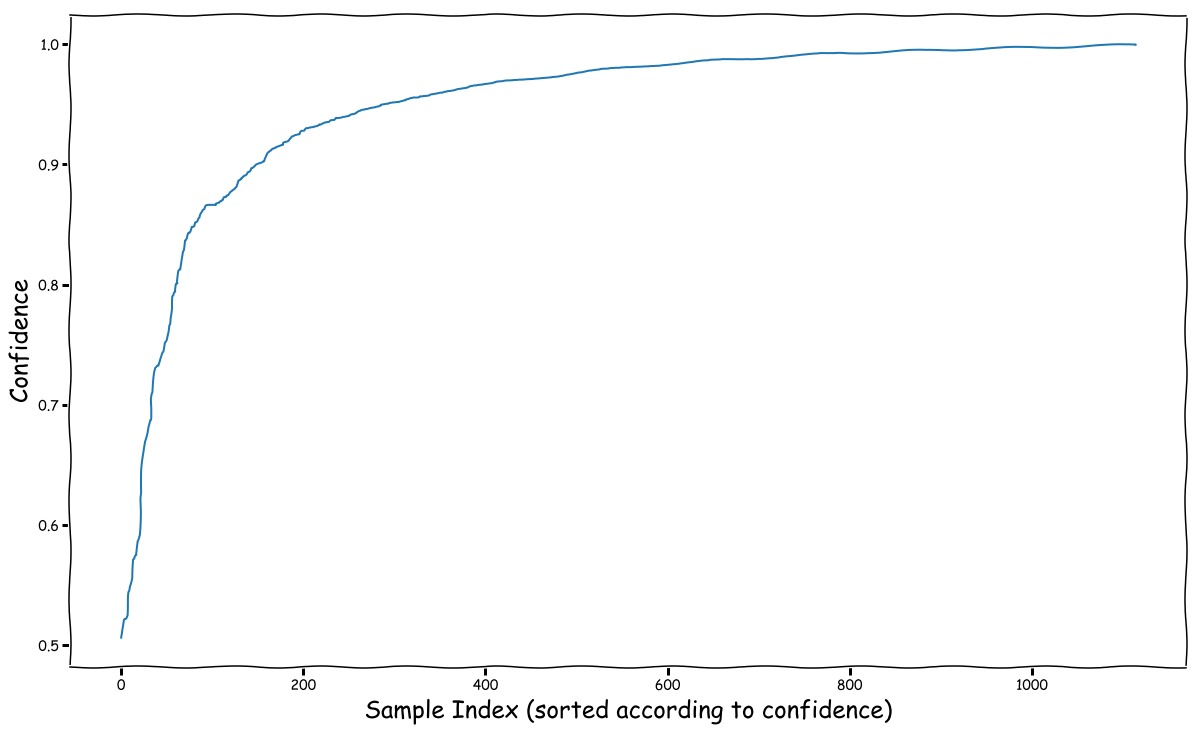

In [40]:
predicted_probabilities = np.max(model.predict_proba(X_test), axis=1)
sorted_predicted_probabilities_indices = np.argsort(predicted_probabilities)

plt.plot(sorted(predicted_probabilities))
plt.xlabel('Sample Index (sorted according to confidence)');
plt.ylabel('Confidence');

We can see that while the model is very confident for most of the samples, there are about 100 samples (~10%) with low confidence.  

Note that we define confidence as the prediction probability of the predicted class.  
Since there are only 2 classes, the minimal value of confidence in this case is 0.5.

Next, let's review some of examples that got the lowest confidence.  
We can see that in many of these cases, our model misclassifies them.

In [41]:
examples = [(y_test.iloc[x], model.predict([X_test.iloc[x]])[0], X_test.iloc[x]) for x in sorted_predicted_probabilities_indices[:20]]
pd.DataFrame(examples, columns=['y', 'prediction', 'text'])

,y,prediction,text
0,spam,ham,Refused a loan? Secured or Unsecured? Can't ge...
1,spam,spam,Send a logo 2 ur lover - 2 names joined by a h...
2,spam,ham,For taking part in our mobile survey yesterday...
3,spam,spam,22 days to kick off! For Euro2004 U will be ke...
4,spam,ham,FREE MSG:We billed your mobile number by mista...
5,spam,ham,XCLUSIVE@CLUBSAISAI 2MOROW 28/5 SOIREE SPECIAL...
6,spam,ham,Reply with your name and address and YOU WILL ...
7,spam,spam,LORD OF THE RINGS:RETURN OF THE KING in store ...
8,spam,spam,FREE GAME. Get Rayman Golf 4 FREE from the O2 ...
9,spam,ham,http//tms. widelive.com/index. wml?id=820554ad...


### Is the model confidence correlated with its performance?
Now, let's examine the model's performance as a function of its confidence (ie the probability it assigns to the predicted class).  
We first get predictions on the test set, and save whether they are correct or not.  
We then use Seaborn's `regplot` to plot average performance, using `x_bins=20`.

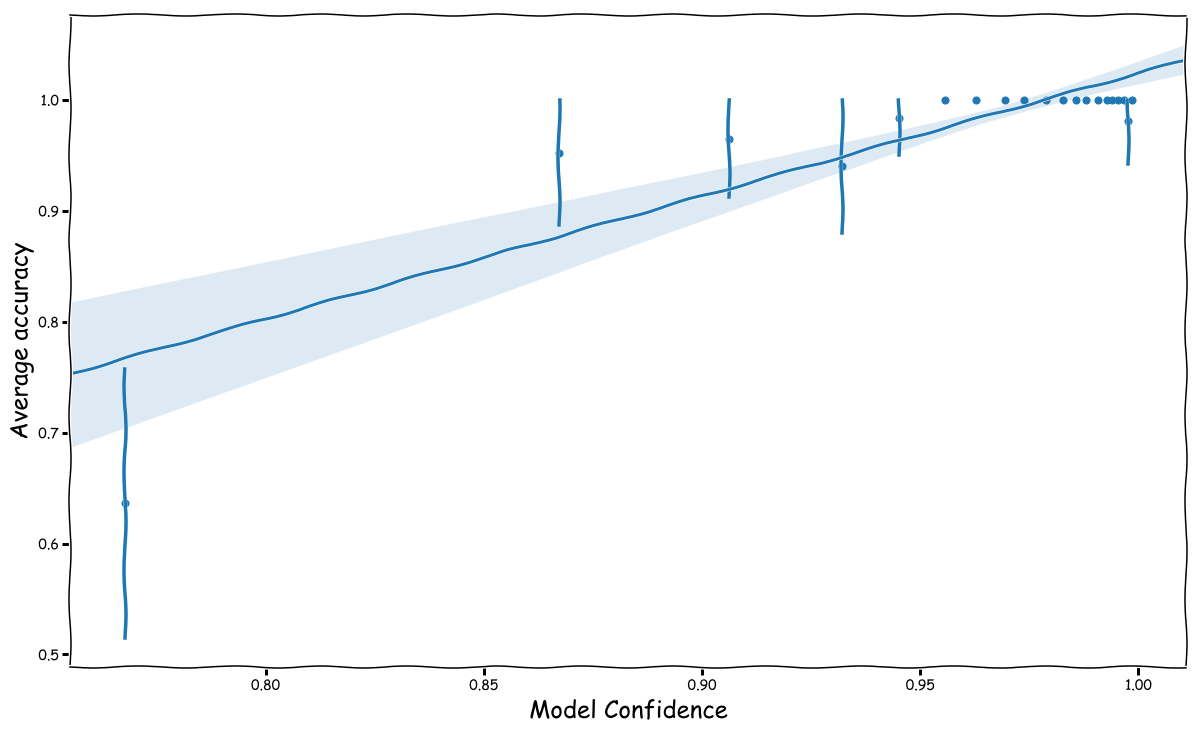

In [42]:
is_correct = (y_test == model.predict(X_test))
ax = sns.regplot(x=predicted_probabilities, y=is_correct, x_bins=20)
# ax = sns.regplot(x=predicted_probabilities, y=is_correct, x_bins=np.arange(0.1,1,.05))
plt.xlabel('Model Confidence')
plt.ylabel('Average accuracy')

As we can see, our model is pretty aware of its performance - it performs well when its confidence is high, and makes more mistakes when his confidence is low.

This serves as a trigger for Active Learning.

## Learning Curve
Let's plot the learning curve of the classifier - its performance based on the number of samples labeled.  

Each time, we take a subset of the train dataset, and use only it to train the model.  
We then calculate performance on the test set (that's left intact).  
We append the results of each run into a `history` variable.

In [43]:
# train_set_size_list = [10,20,30,40,50,75,100,150,200,250,300,350,400,450] + list(np.arange(500,1500,100)) + list(np.arange(1700,5000,250)) + list(np.arange(5500,10000,500))
train_set_size_list = [10,20,30,40] + list(np.arange(50,500,20)) + list(np.arange(500,4000,100))
history = []

for train_set_size in train_set_size_list:
    labeled_instances = X_train[:train_set_size]
    y_labeled_instances = y_train[:train_set_size]
    model.fit(labeled_instances, y_labeled_instances)
    pred_test = model.predict(X_test)

    history.append({"num_labels": len(labeled_instances),
                "labels": labeled_instances,
                "model": model,
                # "accuracy_labeled_instances": accuracy_score(y_true=y_labeled_instances,y_pred=model.predict(labeled_instances)),
                # "f1_labeled_instances": f1_score(y_true=y_labeled_instances,y_pred=model.predict(labeled_instances), average='macro'),
                "accuracy": accuracy_score(y_true=y_test,y_pred=pred_test),
                "f1": f1_score(y_true=y_test,y_pred=pred_test, average='macro'),
               })


C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [50]:
def learning_curve(model, train_set_size_list, X_train, y_train, X_test, y_test):
    history = []

    for train_set_size in train_set_size_list:
        labeled_instances = X_train[:train_set_size]
        y_labeled_instances = y_train[:train_set_size]
        model.fit(labeled_instances, y_labeled_instances)
        pred_test = model.predict(X_test)

        history.append({"num_labels": len(labeled_instances),
                    "labels": labeled_instances,
                    "model": model,
                    # "accuracy_labeled_instances": accuracy_score(y_true=y_labeled_instances,y_pred=model.predict(labeled_instances)),
                    # "f1_labeled_instances": f1_score(y_true=y_labeled_instances,y_pred=model.predict(labeled_instances), average='macro'),
                    "accuracy": accuracy_score(y_true=y_test,y_pred=pred_test),
                    "f1": f1_score(y_true=y_test,y_pred=pred_test, average='macro'),
                   })

    return history

In [51]:
# train_set_size_list = [10,20,30,40,50,75,100,150,200,250,300,350,400,450] + list(np.arange(500,1500,100)) + list(np.arange(1700,5000,250)) + list(np.arange(5500,10000,500))
train_set_size_list = [10,20,30,40] + list(np.arange(50,500,20)) + list(np.arange(500,4000,100))
history = learning_curve(model, train_set_size_list, X_train, y_train, X_test, y_test)

C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


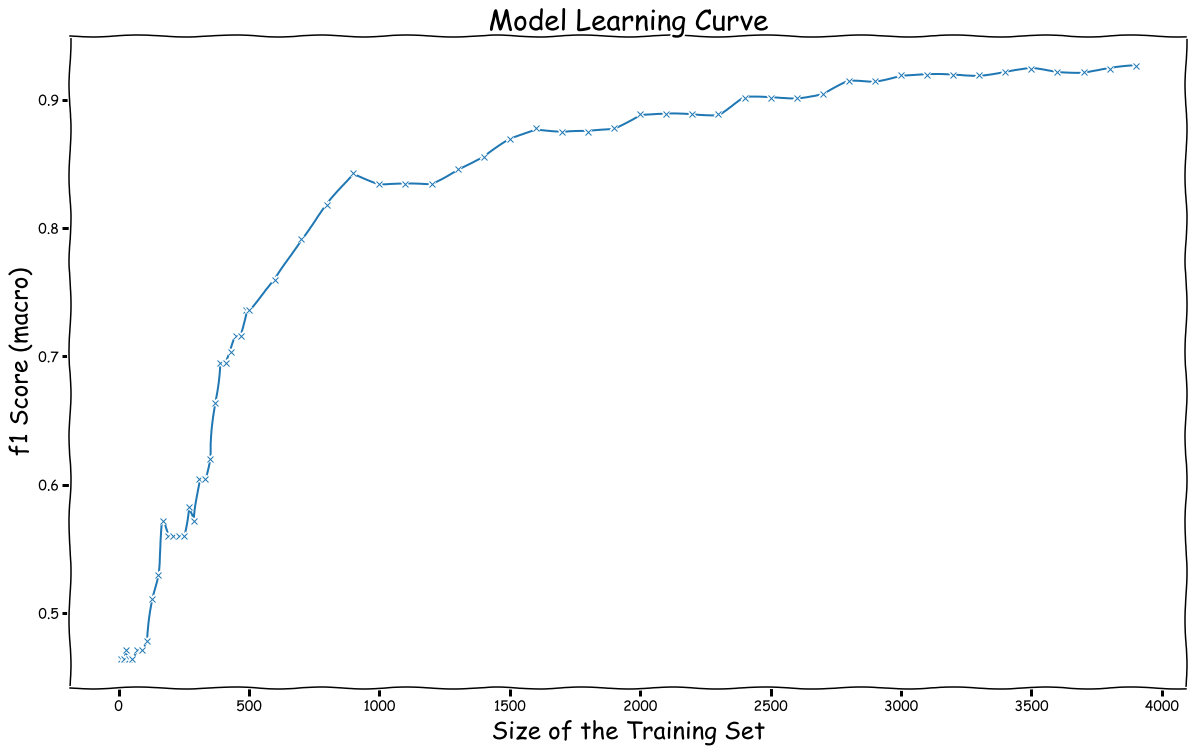

In [52]:
f1 = [i['f1'] for i in history]
num_labels = [i['num_labels'] for i in history]

plt.plot(num_labels, f1, '-x')
plt.xlabel('Size of the Training Set')
plt.ylabel('f1 Score (macro)')
plt.title('Model Learning Curve')

# Applying Active Learning
Let's compare this to an Active Learning algorithm:

In [45]:
df = pd.DataFrame([(x, y) for x,y in zip(X_train, y_train)], columns=['X', 'y'])
print(df.shape)
df.head()

(4457, 2)


,X,y
0,G.W.R,ham
1,What happened to our yo date?,ham
2,We'll join the &lt;#&gt; bus,ham
3,Kit Strip - you have been billed 150p. Netcoll...,spam
4,Sure thing big man. i have hockey elections at...,ham


In [46]:
def run_active_learner(df, model, num_samples_in_active_learning_batch, select_next_batch_func):
    al_history = []
    labeled = pd.DataFrame([])

    # We first mark all data points as unused. We'll update this column whenever we already used a data point.
    df['used']= False
    df['confidence'] = 0

    df = df.sample(frac=1) # Get a random permutation of the dataframe
    X_all = np.array(df['X'].tolist())

    for current_batch_size in num_samples_in_active_learning_batch:
        # select_next_batch_func() is a function we pass as a parameter. This allows us to set smart batch selection mechanisms
        next_labels = select_next_batch_func(df, current_batch_size)

        next_label_indices = next_labels.index
        df.loc[next_label_indices, 'used'] = True

        labeled = labeled.append(next_labels)
        next_labels['step'] = len(labeled)

        X_labeled = np.array(labeled['X'].tolist())

        print('fitting a model for {} labeled instances...'.format(len(labeled)))

        # Fit the model on instances that have a label
        model.fit(X_labeled, y=labeled['y'].values)

        # Predict probabilities of all instances (labeled + yet unlabeled)
        probs = model.predict_proba(X_all)
        df['confidence'] = np.max(probs, axis=1)
        # df['prediction'] = model.predict(X_all)

        pred_test = model.predict(X_test)
        
        # Save model performance
        al_history.append({"num_labeled": len(labeled),
                        "labeled": labeled,
                        "model": model,
                        "accuracy": accuracy_score(y_true=y_test, y_pred=pred_test),
                        "f1": f1_score(y_true=y_test, y_pred=pred_test, average='macro')
                       })

    return al_history

In [47]:
def select_next_batch_func(df, batch_size):
    df = df.sort_values(by=['used','confidence'], ascending=[True,True])
    next_labels = df[:batch_size]
    return next_labels

In [21]:
num_samples_in_active_learning_batch = [50] + [10]*150 + [25]*100
al_history = run_active_learner(df, model, num_samples_in_active_learning_batch, select_next_batch_func)

fitting a model for 50 labeled instances...
fitting a model for 60 labeled instances...


C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 70 labeled instances...
fitting a model for 80 labeled instances...
fitting a model for 90 labeled instances...
fitting a model for 100 labeled instances...
fitting a model for 110 labeled instances...
fitting a model for 120 labeled instances...
fitting a model for 130 labeled instances...
fitting a model for 140 labeled instances...
fitting a model for 150 labeled instances...
fitting a model for 160 labeled instances...
fitting a model for 170 labeled instances...
fitting a model for 180 labeled instances...
fitting a model for 190 labeled instances...
fitting a model for 200 labeled instances...
fitting a model for 210 labeled instances...
fitting a model for 220 labeled instances...
fitting a model for 230 labeled instances...
fitting a model for 240 labeled instances...
fitting a model for 250 labeled instances...
fitting a model for 260 labeled instances...
fitting a model for 270 labeled instances...
fitting a model for 280 labeled instances...
fitting a mod

fitting a model for 2375 labeled instances...
fitting a model for 2400 labeled instances...
fitting a model for 2425 labeled instances...
fitting a model for 2450 labeled instances...
fitting a model for 2475 labeled instances...
fitting a model for 2500 labeled instances...
fitting a model for 2525 labeled instances...
fitting a model for 2550 labeled instances...
fitting a model for 2575 labeled instances...
fitting a model for 2600 labeled instances...
fitting a model for 2625 labeled instances...
fitting a model for 2650 labeled instances...
fitting a model for 2675 labeled instances...
fitting a model for 2700 labeled instances...
fitting a model for 2725 labeled instances...
fitting a model for 2750 labeled instances...
fitting a model for 2775 labeled instances...
fitting a model for 2800 labeled instances...
fitting a model for 2825 labeled instances...
fitting a model for 2850 labeled instances...
fitting a model for 2875 labeled instances...
fitting a model for 2900 labeled i

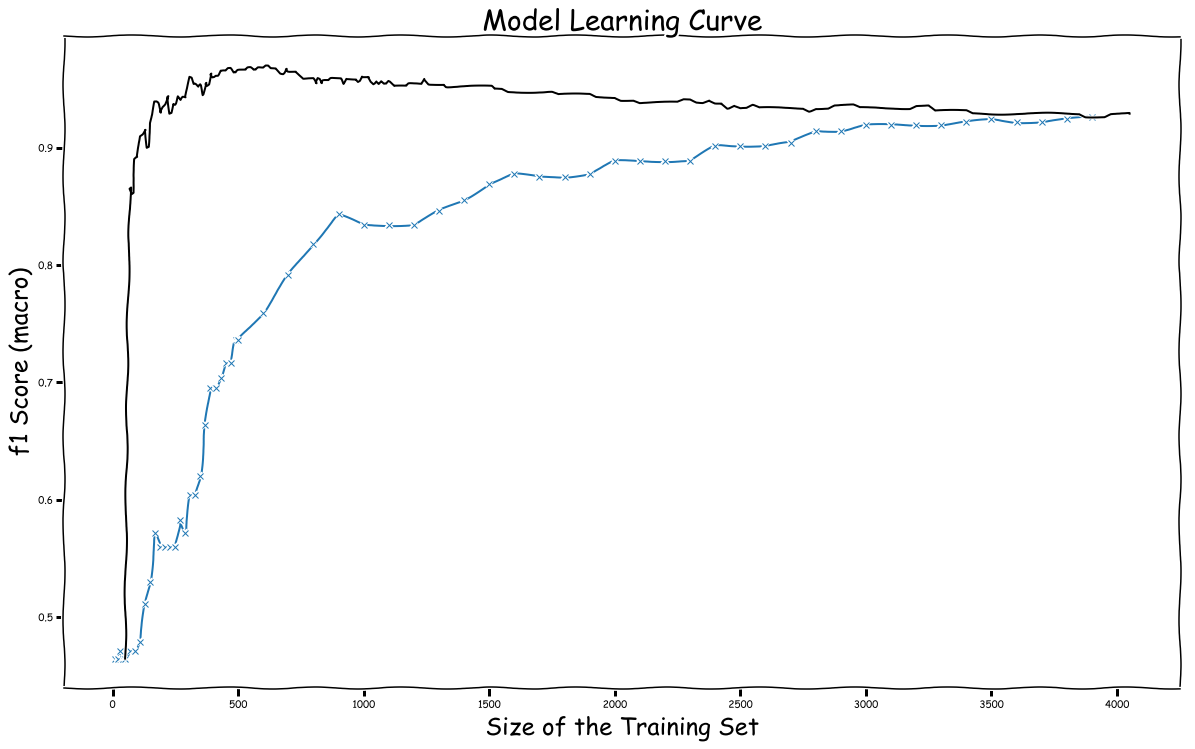

In [22]:
f1 = [i['f1'] for i in history]
num_labels = [i['num_labels'] for i in history]
plt.plot(num_labels, f1, '-x')

plt.plot([v['num_labeled'] for v in al_history], [v['f1'] for v in al_history], '-k')
plt.xlabel('Size of the Training Set')
plt.ylabel('f1 Score (macro)')
plt.title('Model Learning Curve')

## Using selected instances in a new model
Next, let's check if the observations we asked to label based on the confidence of the Logistic Regression model are helpful for other models. We'll train a SVM model with a Radial Basis Function.  
We'll plot its learning curve for randomly selected samples along with the learning curve for observations that were chosen for labeling in our previous Logistic Regression classifier.

In [56]:
from sklearn.linear_model import LogisticRegression
model2 = Pipeline([('vect', CountVectorizer(stop_words='english')),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression(penalty='l1')),
])

In [57]:
train_set_size_list = [10,20,30,40] + list(np.arange(50,500,20)) + list(np.arange(500,4000,100))
history_logistic_regression = learning_curve(model2, train_set_size_list, X_train, y_train, X_test, y_test)

C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\omri.allouche\Anaco

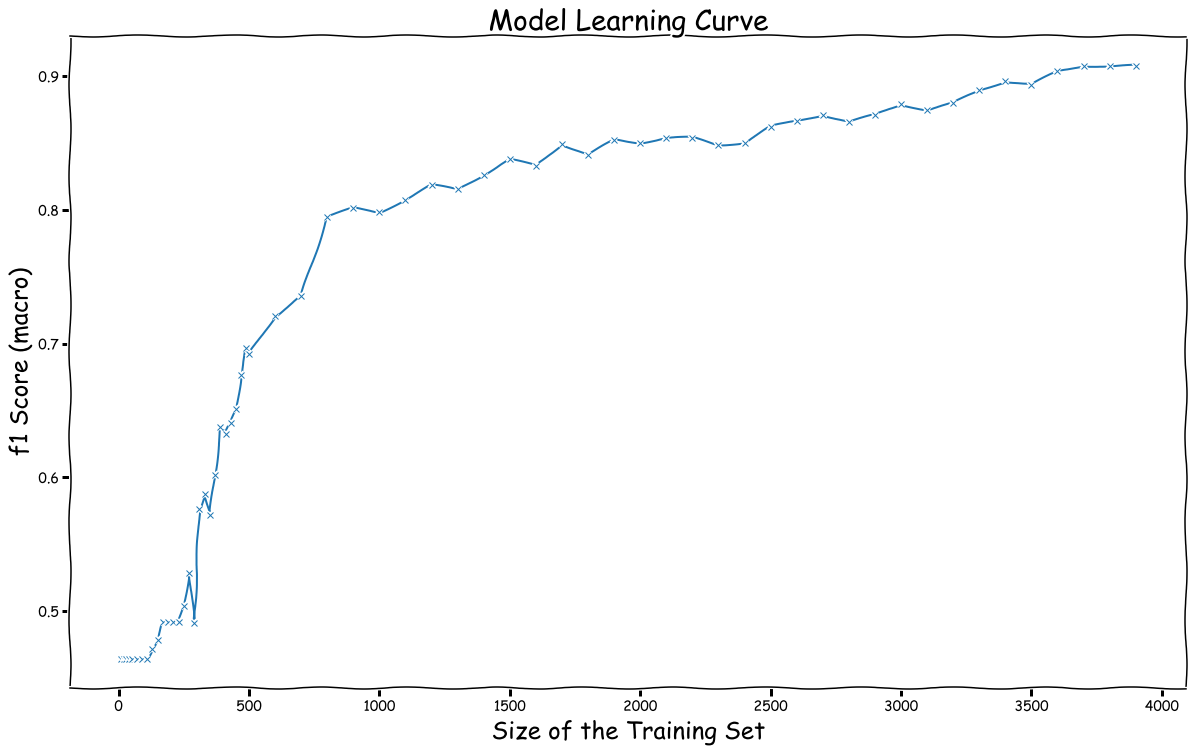

In [58]:
f1 = [i['f1'] for i in history_logistic_regression]
num_labels = [i['num_labels'] for i in history_logistic_regression]

plt.plot(num_labels, f1, '-x')
plt.xlabel('Size of the Training Set')
plt.ylabel('f1 Score (macro)')
plt.title('Model Learning Curve')

In [59]:
def run_active_learner_with_different_model(df, model, model2, num_samples_in_active_learning_batch, select_next_batch_func):
    al_history = []
    labeled = pd.DataFrame([])

    # We first mark all data points as unused. We'll update this column whenever we already used a data point.
    df['used']= False
    df['confidence'] = 0

    df = df.sample(frac=1) # Get a random permutation of the dataframe
    X_all = np.array(df['X'].tolist())

    for current_batch_size in num_samples_in_active_learning_batch:
        # select_next_batch_func() is a function we pass as a parameter. This allows us to set smart batch selection mechanisms
        next_labels = select_next_batch_func(df, current_batch_size)

        next_label_indices = next_labels.index
        df.loc[next_label_indices, 'used'] = True

        next_labels['step'] = len(labeled)
        labeled = labeled.append(next_labels)
  
        X_labeled = np.array(labeled['X'].tolist())

        print('fitting a model for {} labeled instances...'.format(len(labeled)))

        # Fit the model on instances that have a label
        model.fit(X_labeled, y=labeled['y'].values)
        model2.fit(X_labeled, y=labeled['y'].values)

        # Predict probabilities of all instances (labeled + yet unlabeled)
        probs = model.predict_proba(X_all)
        df['confidence'] = np.max(probs, axis=1)
        # df['prediction'] = model.predict(X_all)

        # Save model performance
        pred_test = model.predict(X_test)
        model2_pred_test = model2.predict(X_test)
        al_history.append({"num_labeled": len(labeled),
                        "labeled": labeled,
                        "model": model,
                        "accuracy": accuracy_score(y_true=y_test, y_pred=pred_test),
                        "f1": f1_score(y_true=y_test, y_pred=pred_test, average='macro'),
                        "accuracy_model2": accuracy_score(y_true=y_test, y_pred=model2_pred_test),
                        "f1_model2": f1_score(y_true=y_test, y_pred=model2_pred_test, average='macro')
                       })

    return al_history

In [64]:
num_samples_in_active_learning_batch = [50] + [10]*150 + [25]*100
# num_samples_in_active_learning_batch = [50] + [10]*150

al_history_model2 = run_active_learner_with_different_model(df, model, model2, num_samples_in_active_learning_batch, select_next_batch_func)

fitting a model for 50 labeled instances...
fitting a model for 60 labeled instances...


C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 70 labeled instances...
fitting a model for 80 labeled instances...
fitting a model for 90 labeled instances...
fitting a model for 100 labeled instances...
fitting a model for 110 labeled instances...
fitting a model for 120 labeled instances...
fitting a model for 130 labeled instances...
fitting a model for 140 labeled instances...
fitting a model for 150 labeled instances...
fitting a model for 160 labeled instances...
fitting a model for 170 labeled instances...
fitting a model for 180 labeled instances...
fitting a model for 190 labeled instances...
fitting a model for 200 labeled instances...
fitting a model for 210 labeled instances...
fitting a model for 220 labeled instances...
fitting a model for 230 labeled instances...
fitting a model for 240 labeled instances...
fitting a model for 250 labeled instances...
fitting a model for 260 labeled instances...
fitting a model for 270 labeled instances...
fitting a model for 280 labeled instances...
fitting a mod

fitting a model for 2375 labeled instances...
fitting a model for 2400 labeled instances...
fitting a model for 2425 labeled instances...
fitting a model for 2450 labeled instances...
fitting a model for 2475 labeled instances...
fitting a model for 2500 labeled instances...
fitting a model for 2525 labeled instances...
fitting a model for 2550 labeled instances...
fitting a model for 2575 labeled instances...
fitting a model for 2600 labeled instances...
fitting a model for 2625 labeled instances...
fitting a model for 2650 labeled instances...
fitting a model for 2675 labeled instances...
fitting a model for 2700 labeled instances...
fitting a model for 2725 labeled instances...
fitting a model for 2750 labeled instances...
fitting a model for 2775 labeled instances...
fitting a model for 2800 labeled instances...
fitting a model for 2825 labeled instances...
fitting a model for 2850 labeled instances...
fitting a model for 2875 labeled instances...
fitting a model for 2900 labeled i

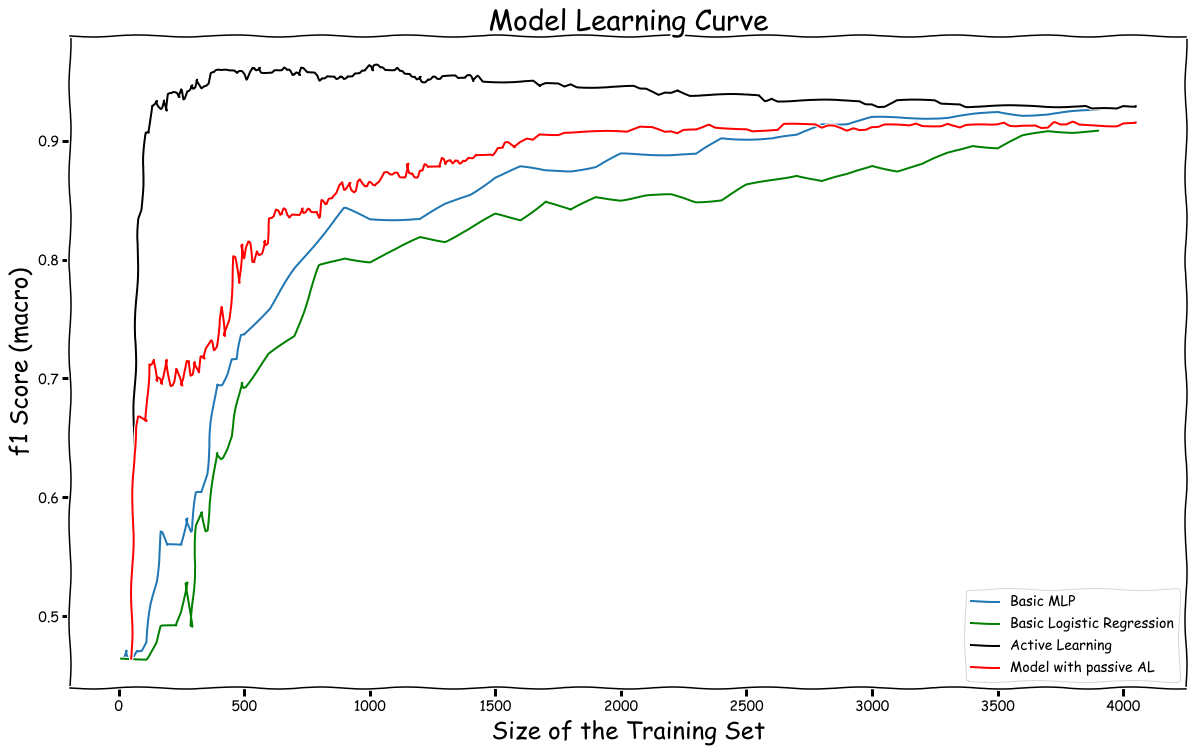

In [65]:
f1 = [i['f1'] for i in history]
num_labels = [i['num_labels'] for i in history]
plt.plot(num_labels, f1, '-')

f1 = [i['f1'] for i in history_logistic_regression]
num_labels = [i['num_labels'] for i in history_logistic_regression]
plt.plot(num_labels, f1, '-g')

plt.plot([v['num_labeled'] for v in al_history_model2], [v['f1'] for v in al_history_model2], '-k')
plt.plot([v['num_labeled'] for v in al_history_model2], [v['f1_model2'] for v in al_history_model2], '-r')
plt.xlabel('Size of the Training Set')
plt.ylabel('f1 Score (macro)')
plt.title('Model Learning Curve')
plt.legend(['Basic MLP', 'Basic Logistic Regression', 'Active Learning', 'Model with passive AL'])

## Bootstraping Results
Let's try a cycle (or more) of bootstraping - we'll use predictions with high confidence of the model as "ground truth" for another round of predictions.

In [23]:
BOOTSTRAP_TH = 0.95

def run_active_learner_with_bootstrap(df, model, num_samples_in_active_learning_batch, select_next_batch_func, bootstrap):
    al_history = []
    labeled = pd.DataFrame([])

    # We first mark all data points as unused. We'll update this column whenever we already used a data point.
    df['used']= False
    df['confidence'] = 0

    df = df.sample(frac=1)
    X_all = np.array(df['X'].tolist())

    for current_batch_size in num_samples_in_active_learning_batch:
        next_labels = select_next_batch_func(df, current_batch_size)

        next_label_indices = next_labels.index
        df.loc[next_label_indices, 'used'] = True

        labeled = labeled.append(next_labels)
        next_labels['step'] = len(labeled)

        X_labeled = np.array(labeled['X'].tolist())

        print('fitting a model for {} labeled instances...'.format(len(labeled)))

        model.fit(X_labeled, y=labeled['y'].values)

        probs = model.predict_proba(X_all)
        df['confidence'] = np.max(probs, axis=1)
        df['prediction'] = model.predict(X_all)

        if bootstrap is not None:
            for i in range(bootstrap):
                confident_instances = set()
                confident_instances = confident_instances | set(df[ df.confidence>BOOTSTRAP_TH ].index.values)
                confident_instances = confident_instances | set(df[ df.prediction=='spam' ].confidence.sort_values().iloc[:10].index.values)
                
                model.fit(df.loc[confident_instances]['X'],
                          y=df.loc[confident_instances]['prediction'])
                probs = model.predict_proba(X_all)
                df['confidence'] = np.max(probs, axis=1)
                df['prediction'] = model.predict(X_all)

        pred_test = model.predict(X_test)
        al_history.append({"num_labeled": len(labeled),
                        "labeled": labeled,
                        "model": model,
                        "accuracy": accuracy_score(y_true=y_test,y_pred=pred_test),
                        "f1": f1_score(y_true=y_test,y_pred=pred_test, average='macro')
                       })

    return al_history

In [26]:
num_samples_in_active_learning_batch = [100] + [10]*30
# al_history = run_active_learner(df, model, num_samples_in_active_learning_batch, select_next_batch_func)
al_history_bootstrap_2 = run_active_learner_with_bootstrap(df, model, num_samples_in_active_learning_batch, select_next_batch_func, bootstrap=2)

fitting a model for 100 labeled instances...


C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 110 labeled instances...
fitting a model for 120 labeled instances...


C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 130 labeled instances...


C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 140 labeled instances...
fitting a model for 150 labeled instances...


C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 160 labeled instances...


C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 170 labeled instances...
fitting a model for 180 labeled instances...


C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 190 labeled instances...
fitting a model for 200 labeled instances...
fitting a model for 210 labeled instances...
fitting a model for 220 labeled instances...
fitting a model for 230 labeled instances...
fitting a model for 240 labeled instances...
fitting a model for 250 labeled instances...


C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 260 labeled instances...
fitting a model for 270 labeled instances...


C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 280 labeled instances...
fitting a model for 290 labeled instances...
fitting a model for 300 labeled instances...
fitting a model for 310 labeled instances...
fitting a model for 320 labeled instances...


C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:461: RuntimeWarning: divide by zero encountered in log
  self.class_log_prior_ = (np.log(self.class_count_) -
C:\Users\omri.allouche\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


fitting a model for 330 labeled instances...
fitting a model for 340 labeled instances...
fitting a model for 350 labeled instances...
fitting a model for 360 labeled instances...
fitting a model for 370 labeled instances...
fitting a model for 380 labeled instances...
fitting a model for 390 labeled instances...
fitting a model for 400 labeled instances...


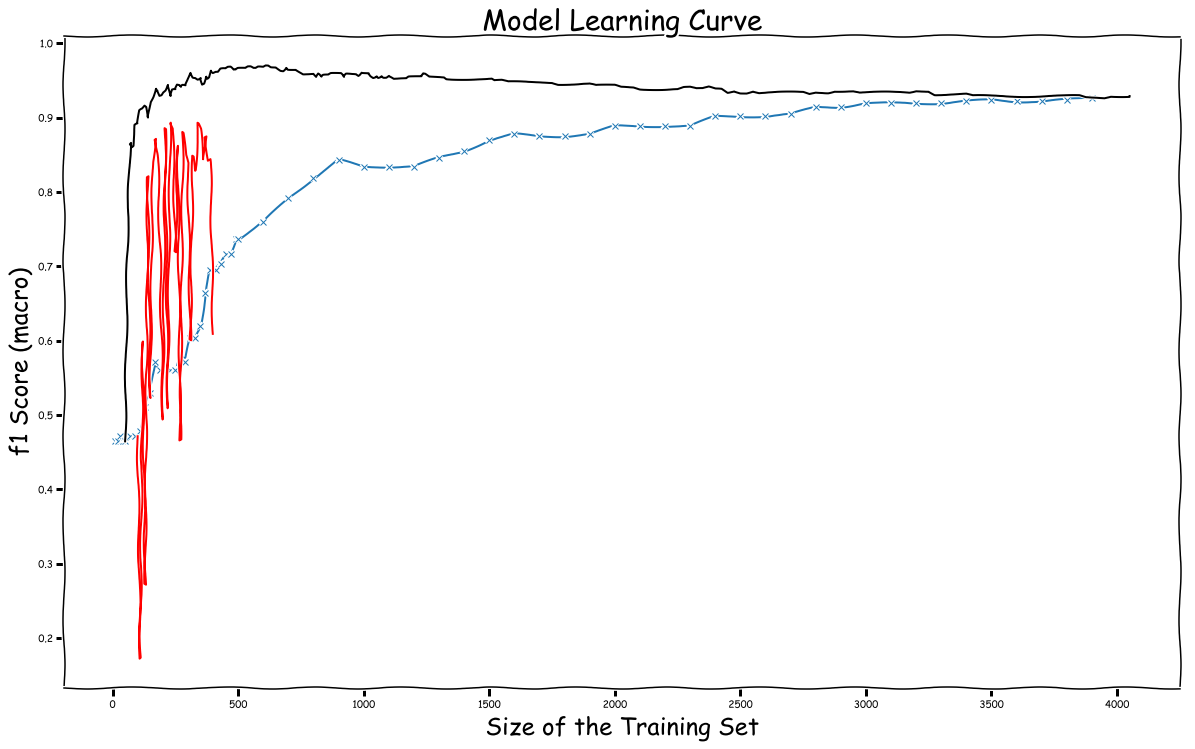

In [27]:
f1 = [i['f1'] for i in history]
num_labels = [i['num_labels'] for i in history]
plt.plot(num_labels, f1, '-x')

plt.plot([v['num_labeled'] for v in al_history], [v['f1'] for v in al_history], '-k')
plt.plot([v['num_labeled'] for v in al_history_bootstrap_1], [v['f1'] for v in al_history_bootstrap_1], '-r')
plt.xlabel('Size of the Training Set')
plt.ylabel('f1 Score (macro)')
plt.title('Model Learning Curve')